# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Predicting Backorders
### Model Selection & Parameter Tuning (details)

In [1]:
# Import libraries 
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import visuals as vs
import xgboost

# Display options
from IPython.display import display # Allows the use of display() for DataFrames
import warnings # hide warnings
warnings.filterwarnings('ignore')
# pretty display
%matplotlib inline 

# Load data
try:
    train_df = pd.read_csv("./processed_train.csv", low_memory = False)
    print("Training dataset has {} samples with {} features each.".format(*train_df.shape))
    test_df = pd.read_csv("./processed_test.csv", low_memory = False)
    print("Testing dataset has {} samples with {} features each.".format(*test_df.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Training dataset has 1586967 samples with 23 features each.
Testing dataset has 227351 samples with 23 features each.


In [2]:
# reset index to sku
train_df = train_df.set_index('sku'); test_df= test_df.set_index('sku')
# remove rows with NaN for all values
train_df = train_df.dropna(how = 'all')

### Benchmark Predictor Performance

The naive predictor for our benchmark predictor is one that always predict an order without any backorder. Due to the low backorder rate, the accuracy and F-score of the benchmark predictor are really high.

In [5]:
from sklearn.metrics import confusion_matrix

# Get data characteristics on the training set
n_orders = len(train_df)
n_features = len(train_df.iloc[0]) - 1  # Don't count target column
n_bo = len(train_df[train_df['went_on_backorder'] == 1])
n_nobo = len(train_df[train_df['went_on_backorder'] == 0])
bo_rate = float(n_bo)/n_orders * 100

# Benchmark predictor
# accuracy = # predicted right/total
accuracy =1.*n_nobo/n_orders

#Precision = TP / (TP+FP) 
#Recall = TP / (TP+FN)
beta = 0.5
precision = 1.*n_nobo /(n_nobo + n_bo)
recall = 1.*n_nobo/ (n_nobo + 0) 
fscore = (1+beta**2)*precision*recall /(beta**2*precision+recall)

# calculate kappa
a = n_nobo; b = n_bo; c = d = 0
p0 = accuracy
pNoBo = (a+b)/n_orders*(a+c)/n_orders
pBo = (c+d)/n_orders*(b+d)/n_orders
pE = pNoBo + pBo
kappa = (p0 - pE)/(1-pE)

naive_df = pd.DataFrame([precision, recall, fscore,kappa], index=['Precision', 'Recall', 'F1 score', 'Kappa'], columns=['Benchmark Predictor'])
naive_df

,Benchmark Predictor
Precision,0.993088
Recall,1.000000
F1 score,0.994463
Kappa,0.993088


# III. Model Selection

Due to the highly imbalanced dataset with 1:143 ratio, we cannot rely on accuracy as it is misleading Because we have really imbalanced dataset with 1:143 ratio, we know we cannot rely on accurcy as it's misleading due to the accuracy paradox. Accuracy only reflects the underlying distribution when the data is imbalanced. 

The metrics that we will examine are: 
- confusion matrix: 2 by 2 table showing types of correct and incorrect predictions
- precision: measure of classification exactness
- recall: measure of classification completeness
- F1 score: weighted average of precision and recall
- Cohen's kappa: classification accuracy normalized by the imbalance of the data
- ROC curve: graphical examination of sensitivity vs 1-specificity. 

We will pick the supervised machine learning method through model performance on validation set. The five methods that we are interested are: 
- **Gradient Boosting Classifier**: a principled method of dealing with class imbalance by constructing successive training sets based on incorrectly classified examples.
- **Random Forest classifier**: bagging-based ensemble method. 
- **Decision Tree classifier**: this method is based on 'gini index' or 'entropy,' which doesn't rely on accuracy. 
- **AdaBoost classifier**: AdaBoost can achieve similar classification results with much less parameter tuning. 
- **Bagging classifier**: ensemble method. 

In [6]:
from sklearn import cross_validation
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

features = train_df.drop('went_on_backorder', axis=1, inplace=False).columns.values.tolist()

X_train, X_validation, y_train, y_validation = cross_validation.train_test_split(train_df[features],train_df['went_on_backorder'],
                                                                     test_size=0.2, random_state=0)
#create classifiers
xgbclf = XGBClassifier(random_state=100) 
gbclf = GradientBoostingClassifier(random_state=100) 
rfclf = RandomForestClassifier(random_state=100) 
dtclf = DecisionTreeClassifier(random_state=100) 
abclf = AdaBoostClassifier(random_state=100) 
bclf = BaggingClassifier(random_state=100)

# train classifiers
xgbclf.fit(X_train, y_train)
gbclf.fit(X_train, y_train)
rfclf.fit(X_train, y_train)
dtclf.fit(X_train, y_train)
abclf.fit(X_train, y_train)
bclf.fit(X_train, y_train)

# obtain predictions
xgbpreds = xgbclf.predict(X_validation)
gbpreds = gbclf.predict(X_validation)
rfpreds = rfclf.predict(X_validation)
dtpreds = dtclf.predict(X_validation)
abpreds = abclf.predict(X_validation)
bpreds = bclf.predict(X_validation)

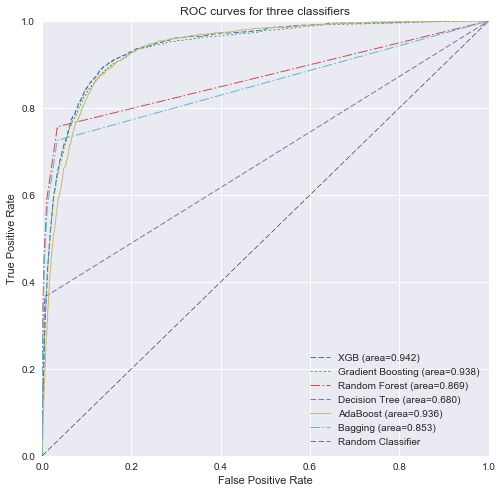

In [7]:
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_proba[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(y_true, y_proba[:,1])))
    
f, ax = plt.subplots(figsize=(8,8))

roc_auc_plot(y_validation, xgbclf.predict_proba(X_validation),label='XGB',l='--')
roc_auc_plot(y_validation, gbclf.predict_proba(X_validation),label='Gradient Boosting', l=':')
roc_auc_plot(y_validation, rfclf.predict_proba(X_validation),label='Random Forest',l='-.')
roc_auc_plot(y_validation, dtclf.predict_proba(X_validation),label='Decision Tree',l='--')
roc_auc_plot(y_validation, abclf.predict_proba(X_validation),label='AdaBoost',l='-')
roc_auc_plot(y_validation, bclf.predict_proba(X_validation),label='Bagging',l='-.')

ax.plot([0,1], [0,1], color='black', linewidth=0.5, linestyle='--', 
        label='Random Classifier')    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('ROC curves for three classifiers')
sns.despine()

In [8]:
from sklearn.metrics import f1_score, cohen_kappa_score, precision_score, recall_score, confusion_matrix

# get statistics
xgb_cm = confusion_matrix(y_validation, xgbpreds)
xgb_precision = precision_score(y_validation, xgbpreds)  
xgb_recall = recall_score(y_validation, xgbpreds) 
xgb_f1 = f1_score(y_validation, xgbpreds) 
xgb_kappa = cohen_kappa_score(y_validation, xgbpreds) 

gb_cm = confusion_matrix(y_validation, gbpreds)
gb_precision = precision_score(y_validation, gbpreds)  
gb_recall = recall_score(y_validation, gbpreds) 
gb_f1 = f1_score(y_validation, gbpreds) 
gb_kappa = cohen_kappa_score(y_validation, gbpreds) 

rf_cm = confusion_matrix(y_validation, rfpreds)
rf_precision = precision_score(y_validation, rfpreds)  
rf_recall = recall_score(y_validation, rfpreds) 
rf_f1 = f1_score(y_validation, rfpreds) 
rf_kappa = cohen_kappa_score(y_validation, rfpreds) 

dt_cm = confusion_matrix(y_validation, dtpreds)
dt_precision = precision_score(y_validation, dtpreds)  
dt_recall = recall_score(y_validation, dtpreds) 
dt_f1 = f1_score(y_validation, dtpreds) 
dt_kappa = cohen_kappa_score(y_validation, dtpreds)

ab_cm = confusion_matrix(y_validation, abpreds)
ab_precision = precision_score(y_validation, abpreds)  
ab_recall = recall_score(y_validation, abpreds) 
ab_f1 = f1_score(y_validation, abpreds) 
ab_kappa = cohen_kappa_score(y_validation, abpreds)

b_cm = confusion_matrix(y_validation, bpreds)
b_precision = precision_score(y_validation, bpreds)  
b_recall = recall_score(y_validation, bpreds) 
b_f1 = f1_score(y_validation, bpreds) 
b_kappa = cohen_kappa_score(y_validation, bpreds)

result = pd.DataFrame({'XGB': [xgb_precision, xgb_recall, xgb_f1, xgb_kappa], 
                       'GB':[gb_precision, gb_recall, gb_f1, gb_kappa], 
                       'RF':[rf_precision, rf_recall, rf_f1, rf_kappa], 
                       'Decision Tree':[dt_precision, dt_recall, dt_f1, dt_kappa],
                       'Adaboost':[ab_precision, ab_recall, ab_f1, ab_kappa],
                       'Bagging':[b_precision, b_recall, b_f1, b_kappa]}, 
                     index = ['Precision', 'Recall', 'F1 score', 'Kappa'])
print(result)


           Adaboost   Bagging  Decision Tree        GB        RF       XGB
Precision  0.226891  0.774138       0.326622  0.578947  0.814000  1.000000
Recall     0.012097  0.201165       0.327061  0.014785  0.182348  0.000448
F1 score   0.022969  0.319346       0.326841  0.028834  0.297950  0.000896
Kappa      0.022273  0.317365       0.322071  0.028493  0.296138  0.000889


In [ ]:
# print confusion matrix 
print 'Bagging Classifier', '                     ', 'Random Forest Classifier', '              ',  'Decision Tree Classifier'
print b_cm[0],'                        ', rf_cm[0], '                       ',  dt_cm[0]
print b_cm[1],'                            ', rf_cm[1], '                           ', dt_cm[1]
print 
print 'Misclassification rate: '
print 1.*(b_cm[0][1]+b_cm[1][0])/X_validation.shape[0], '                       ',  1.*(rf_cm[0][1]+rf_cm[1][0])/X_validation.shape[0], '                      ', 1.*(dt_cm[0][1]+dt_cm[1][0])/X_validation.shape[0], ''
print
print 'Number of False Negative:'
print b_cm[1][0], '                                   ',  rf_cm[1][0], '                                  ', dt_cm[1][0]
 

With ROC curves, we can see that gradient boosting performs the best among the three. For precision/recall, decision tree is the best. For F1 score and Kappa score, decision tree is the best. Since false negative is more important than false positive here (it's better to prepare for a backorder that may not happen instead of missing a backorder that actually will happen), we have gathered the number of false negative and decision tree has the least amount of false negatives. Combine all criteria, we have decided to use decision tree for predicting backorder. 

## Model Tuning



We will first fix learning rate and several estimators for tuning tree-based parameters. The initial estimates will be tuned later as well. Lets take the following values:

- max_depth = 5 : maximum depth of a tree, typically between 3 and 10.
- min_child_weight = 1 : A smaller value is chosen due to our imbalanced outcome. It's also used to control over-fitting. 
- gamma = 0 : gamma specifies the minimum loss reduction required to make a split. A smaller value like 0.1-0.2 can also be chosen for starting. 
- subsample, colsample_bytree = 0.8 : the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. It's typically set between 0.5 and 1. 
- scale_pos_weight = 1: a value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.


In [4]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import cohen_kappa_score, make_scorer, precision_score, recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

scoring_function = make_scorer(cohen_kappa_score, greater_is_better=False)
target = 'went_on_backorder'
predictors = [x for x in train_df.columns if x not in ['went_on_backorder']]

#train = X_train; train['went_on_backorder'] = y_train
#validation = X_validation; validation['went_on_backorder'] = y_validation

In [5]:
# normalize the data to make sure everything is normalized
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(train_df)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.columns = train_df.columns

In [6]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='error', early_stopping_rounds=early_stopping_rounds, verbose_eval= True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['went_on_backorder'],eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
     
    return dtrain_predictions, dtrain_predprob    

In [7]:
# get a benchmark performance with our initial values
xgb1 = XGBClassifier(
 learning_rate =0.5,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=100)

modelfit(xgb1, df_normalized, predictors)

[0]	train-error:0.0069084+2.23839e-05	test-error:0.0069126+8.43009e-05
[1]	train-error:0.0069096+1.98655e-05	test-error:0.0069126+8.43009e-05
[2]	train-error:0.00691+2.19454e-05	test-error:0.006912+8.25009e-05
[3]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[4]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[5]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[6]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[7]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[8]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[9]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[10]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[11]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[12]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[13]	train-error:0.0069118+2.09895e-05	test-error:0.006912+8.42211e-05
[14]	train-error

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score
print "model report:"
df_normalized['pred1'] = m1pred
p1 = precision_score(df_normalized['went_on_backorder'].values, m1pred)
r1 = recall_score(df_normalized['went_on_backorder'].values, m1pred)
f1 = f1_score(df_normalized['went_on_backorder'].values, m1pred)
k1 = cohen_kappa_score(df_normalized['went_on_backorder'].values, m1pred)
a1 =  roc_auc_score(df_normalized['went_on_backorder'], m1prob)
print "Precision : %.4g" % p1
print "Recall : %.4g" % r1
print "f1 score: %.4g" % f1
print "Kappa : %.4g" % k1
print "AUC Score (Train): %f" % a1

Tune max_depth and min_child_weight

We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [39]:
param_test1 = {
 'max_depth':range(3,12,2),
 'min_child_weight':range(1,4,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=51, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=100), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [40]:
gsearch1.fit(df_normalized[predictors],df_normalized[target])
t = list()
for i in range(0,9,2): t.append(gsearch1.grid_scores_[i][1])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.93006, std: 0.00705, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.93005, std: 0.00704, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.94106, std: 0.00571, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.94093, std: 0.00562, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.94811, std: 0.00545, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.94768, std: 0.00555, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.95413, std: 0.00591, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.95365, std: 0.00572, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.95905, std: 0.00681, params: {'max_depth': 11, 'min_child_weight': 1},
  mean: 0.95818, std: 0.00614, params: {'max_depth': 11, 'min_child_weight': 3}],
 {'max_depth': 11, 'min_child_weight': 1},
 0.9590468544812616)

The result on the validation set showed that max_depth is optimized at 9. We'll check the values between 8 and 10 to double check. 

In [41]:
param_test2 = {
 'max_depth': range(12,17,1)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [42]:
gsearch2.fit(df_normalized[predictors],df_normalized[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.96121, std: 0.00708, params: {'max_depth': 12},
  mean: 0.96275, std: 0.00745, params: {'max_depth': 13},
  mean: 0.96407, std: 0.00775, params: {'max_depth': 14},
  mean: 0.96508, std: 0.00754, params: {'max_depth': 15},
  mean: 0.96572, std: 0.00840, params: {'max_depth': 16}],
 {'max_depth': 16},
 0.9657238437956301)

In [43]:
param_test3 = {
 'max_depth': range(17,25,1)
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [44]:
gsearch3.fit(df_normalized[predictors],df_normalized[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.96660, std: 0.00826, params: {'max_depth': 17},
  mean: 0.96660, std: 0.00837, params: {'max_depth': 18},
  mean: 0.96676, std: 0.00868, params: {'max_depth': 19},
  mean: 0.96699, std: 0.00884, params: {'max_depth': 20},
  mean: 0.96710, std: 0.00850, params: {'max_depth': 21},
  mean: 0.96730, std: 0.00886, params: {'max_depth': 22},
  mean: 0.96758, std: 0.00863, params: {'max_depth': 23},
  mean: 0.96734, std: 0.00882, params: {'max_depth': 24}],
 {'max_depth': 23},
 0.9675823549841007)

chose max_depth of 23 and min_child_weight of 1

In [45]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,4)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=23,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [46]:
gsearch4.fit(df_normalized[predictors],df_normalized[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.96758, std: 0.00863, params: {'gamma': 0.0},
  mean: 0.96743, std: 0.00898, params: {'gamma': 0.1},
  mean: 0.96707, std: 0.00870, params: {'gamma': 0.2},
  mean: 0.96716, std: 0.00872, params: {'gamma': 0.3}],
 {'gamma': 0.0},
 0.9675823549841007)

gamma is optimized at 0

In [47]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=23,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [48]:
gsearch5.fit(df_normalized[predictors],df_normalized[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.96468, std: 0.00810, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.96571, std: 0.00849, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.96692, std: 0.00897, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.96773, std: 0.00903, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.96432, std: 0.00814, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.96605, std: 0.00839, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.96651, std: 0.00852, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.96742, std: 0.00856, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.96549, std: 0.00819, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.96665, std: 0.00841, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.96758, std: 0.00863, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.96795, std: 0.00861, params: {'subsample': 0.9, 'colsample_bytree'

In [ ]:
x = [i/10.0 for i in range(0,4)]
plt.plot(x, t4, label = 'training')
plt.plot(x, v4, label = 'validation')
plt.legend(['training', 'validation'], loc='upper left')

In [54]:
param_test6 = {
 'subsample':[i/10.0 for i in range(8,11)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=23,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [55]:
gsearch6.fit(df_normalized[predictors],df_normalized[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.96758, std: 0.00863, params: {'subsample': 0.8},
  mean: 0.96795, std: 0.00861, params: {'subsample': 0.9},
  mean: 0.96820, std: 0.00951, params: {'subsample': 1.0}],
 {'subsample': 1.0},
 0.9681975962461975)

0.8 selected for colsample_bytree and 1.0 selected for subsample

In [57]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=23,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [58]:
gsearch7.fit(df_normalized[predictors],df_normalized[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.96815, std: 0.00949, params: {'reg_alpha': 1e-05},
  mean: 0.96829, std: 0.00903, params: {'reg_alpha': 0.01},
  mean: 0.96787, std: 0.00905, params: {'reg_alpha': 0.1},
  mean: 0.96260, std: 0.00737, params: {'reg_alpha': 1},
  mean: 0.92902, std: 0.00724, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.9682928087937274)

In [59]:
param_test8 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=23,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [60]:
gsearch8.fit(df_normalized[predictors],df_normalized[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.96820, std: 0.00951, params: {'reg_alpha': 0},
  mean: 0.96843, std: 0.00896, params: {'reg_alpha': 0.001},
  mean: 0.96835, std: 0.00898, params: {'reg_alpha': 0.005},
  mean: 0.96829, std: 0.00903, params: {'reg_alpha': 0.01},
  mean: 0.96812, std: 0.00914, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.001},
 0.968426444740446)

reg_alpha selected as 0.001. Now let's tune the learning rate. 

In [9]:
param_test9 = {
 'learning_rate':[0.001, 0.01, 0.1, 0.5, 0.7, 1]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=23,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.8, reg_alpha = 0.001,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [10]:
gsearch9.fit(df_normalized[predictors],df_normalized[target])
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

([mean: 0.93285, std: 0.00655, params: {'learning_rate': 0.001},
  mean: 0.93713, std: 0.00633, params: {'learning_rate': 0.01},
  mean: 0.96893, std: 0.00886, params: {'learning_rate': 0.1},
  mean: 0.97245, std: 0.01186, params: {'learning_rate': 0.5},
  mean: 0.96843, std: 0.01165, params: {'learning_rate': 0.7},
  mean: 0.96408, std: 0.01504, params: {'learning_rate': 1}],
 {'learning_rate': 0.5},
 0.9724457962492759)

In [13]:
param_test10 = {
 'learning_rate':[0.2, 0.3, 0.4, 0.5]
}
gsearch10 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=51, max_depth=23,
 min_child_weight=1, gamma=0, subsample=1.0, colsample_bytree=0.8, reg_alpha = 0.001,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=100), 
 param_grid = param_test10, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [14]:
gsearch10.fit(df_normalized[predictors],df_normalized[target])
gsearch10.grid_scores_, gsearch10.best_params_, gsearch10.best_score_

([mean: 0.97523, std: 0.00968, params: {'learning_rate': 0.2},
  mean: 0.97425, std: 0.00980, params: {'learning_rate': 0.3},
  mean: 0.97322, std: 0.01031, params: {'learning_rate': 0.4},
  mean: 0.97245, std: 0.01186, params: {'learning_rate': 0.5}],
 {'learning_rate': 0.2},
 0.9752335625007955)